<a href="https://colab.research.google.com/github/NicholasLeotta99/Neuromatch_BrainCancer/blob/Dhiren/code/VGG19_Classifier_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Package Imports
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.utils import make_grid
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
from torchsummary import summary

import os
from google.colab import files
from PIL import Image
import subprocess

import random
random.seed(2023)

In [ ]:
# @title Data Loading
print('Upload kaggle.json account information to download the dataset:')
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip -q brain-tumor-mri-dataset.zip

Upload kaggle.json account information to download the dataset:


Saving kaggle.json to kaggle.json
 92% 137M/149M [00:01<00:00, 140MB/s]
100% 149M/149M [00:01<00:00, 106MB/s]


In [ ]:
# @title Download and processing Zenodo data - unneeded, data represented in original dataset
#!wget https://zenodo.org/record/7047164/files/adnoma.zip
#!wget https://zenodo.org/record/7047164/files/Gliomas.zip
#!wget https://zenodo.org/record/7047164/files/Meningioma.zip

def grab_format_zenodo(type='adnoma', size=(256,256)):
  url = f'https://zenodo.org/record/7047164/files/{type}.zip'
  print(f'Downloading {type}')
  subprocess.call(['wget', '-v', url])
  print(f'{type} acquired, unzipping...')
  subprocess.call(['unzip', '-q', f'{type}.zip'])
  files = os.listdir(f'./{type}')
  print(f'Unzipping {type} completed [{len(files)} samples extracted], beginning conversion...')
  size=(256,256)
  for i in files:
    im = Image.open(f'./{type}/{i}')
    i, _ = i.split('.')
    new = im.resize(size)
    if not os.path.isdir(f'./{type}_png'):
      os.mkdir(f'./{type}_png')
    new.save(f'./{type}_png/{i}.png', 'png')

# for i in ['adnoma', 'Gliomas', 'Meningioma']:
#   grab_format_zenodo(type=i)

In [ ]:
# @title Subsampling Validation Data

if not os.path.isdir('./Validation/'):
  os.mkdir('./Validation/')
  classes = os.listdir('./Training/')
  training_samples = []
  for i in classes:
    os.mkdir(f'./Validation/{i}/')
    files = os.listdir(f'./Training/{i}/')
    for f in files:
      training_samples.append(f'/{i}/{f}')
  random.shuffle(training_samples)
  validation_samples = training_samples[0:1100]
  training_samples = training_samples[1100:]
  for samp in validation_samples:
    os.rename(f'./Training{samp}', f'./Validation{samp}')


In [ ]:
classes = os.listdir('./Training/')

0 tensor([2, 1, 2, 0, 2, 0, 2, 2, 0, 3, 1, 2, 0, 2, 2, 2, 2, 1, 1, 1, 3, 2, 2, 3,
        1, 0, 3, 3, 3, 3, 0, 1])


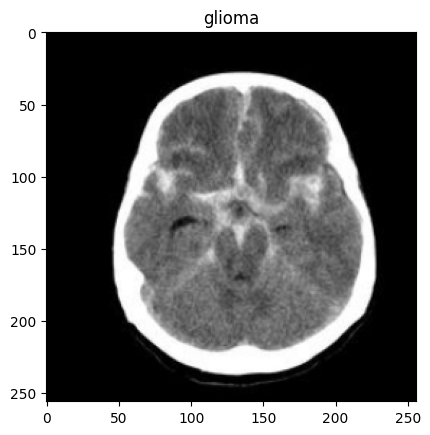

In [ ]:
# @title Dataset Generation
#TODO - Verify labels correspond to classes

data_transf = transforms.Compose([transforms.Resize((256, 256)),
                                  transforms.ToTensor()])

TrainingDataset = ImageFolder(root='./Training/', transform=data_transf)#, transform=torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms)
TrainingLoader = DataLoader(TrainingDataset, batch_size=32, shuffle=True)

ValidationDataset = ImageFolder(root='./Validation/', transform=data_transf)#, transform=torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms)
ValidationLoader = DataLoader(ValidationDataset, batch_size= 32, shuffle=True)

for batch_number , (images, labels) in enumerate(TrainingLoader):
  print(batch_number, labels)
  plt.imshow(torch.moveaxis(images[0], 0, -1))
  plt.title(classes[labels[0]])
  plt.show()
  break

In [ ]:
device= device = torch.device("cuda")

In [ ]:
Classifier = models.vgg19(weights='DEFAULT')

for param in Classifier.features.parameters():
    param.requires_grad = False

num_features = Classifier.classifier[6].in_features


Classifier.classifier[6] = nn.Linear(num_features, 2048).to(device)
Classifier.classifier.add_module('relu1', nn.ReLU(inplace=True).to(device))
Classifier.classifier.add_module('fc1', nn.Linear(2048, 4).to(device))
#Classifier.classifier.add_module('softmax', nn.Softmax(dim=1))



Classifier = Classifier.to(device)
summary(Classifier, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

Epoch 1, Batch 10, Loss: 0.511
Epoch 1, Batch 20, Loss: 0.311
Epoch 1, Batch 30, Loss: 0.270
Epoch 1, Batch 40, Loss: 0.260
Epoch 1, Batch 50, Loss: 0.203
Epoch 1, Batch 60, Loss: 0.238
Epoch 1, Batch 70, Loss: 0.176
Epoch 1, Batch 80, Loss: 0.134
Epoch 1, Batch 90, Loss: 0.140
Epoch 1, Batch 100, Loss: 0.151
Epoch 1, Batch 110, Loss: 0.117
Epoch 1, Batch 120, Loss: 0.151
Epoch 1, Batch 130, Loss: 0.124
Epoch 1, Batch 140, Loss: 0.117
Epoch 1 Loss: 0.658
Epoch 1 Validation Accuracy: 83.45%
Epoch 1 Validation Loss: 0.499
Epoch 2, Batch 10, Loss: 0.139
Epoch 2, Batch 20, Loss: 0.167
Epoch 2, Batch 30, Loss: 0.108
Epoch 2, Batch 40, Loss: 0.104
Epoch 2, Batch 50, Loss: 0.142
Epoch 2, Batch 60, Loss: 0.112
Epoch 2, Batch 70, Loss: 0.108
Epoch 2, Batch 80, Loss: 0.086
Epoch 2, Batch 90, Loss: 0.135
Epoch 2, Batch 100, Loss: 0.105
Epoch 2, Batch 110, Loss: 0.147
Epoch 2, Batch 120, Loss: 0.104
Epoch 2, Batch 130, Loss: 0.119
Epoch 2, Batch 140, Loss: 0.100
Epoch 2 Loss: 0.388
Epoch 2 Validat

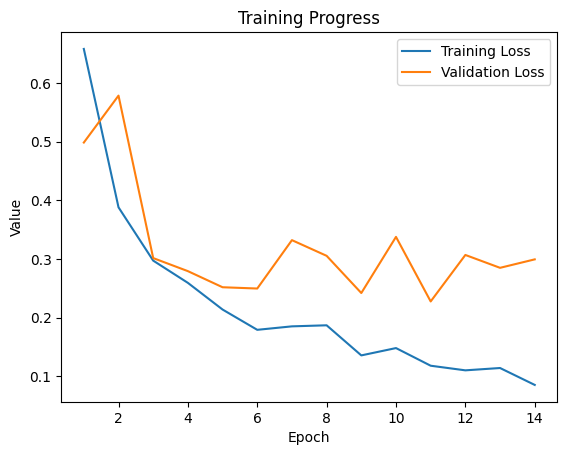

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(Classifier.parameters(), lr=0.001)

num_epochs = 200

epoch_loss = []
val_loss = []
val_accuracy = []

best_loss = np.inf
best_weights = None
patience = 3
no_improvement = 0

for epoch in range(num_epochs):
    train_running_loss = 0.0
    mini_batch_loss = 0.0
    for batch_number, (images, labels) in enumerate(TrainingLoader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = Classifier(images)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
        mini_batch_loss += loss.item()

        if (batch_number + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}, Batch {batch_number + 1}, Loss: {mini_batch_loss / 32:.3f}')
            mini_batch_loss = 0.0

    epoch_loss.append(train_running_loss / len(TrainingLoader))

    # Validation
    correct = 0
    total = 0
    val_running_loss = 0.0

    for images, labels in ValidationLoader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = Classifier(images)
        loss = loss_function(outputs, labels)

        val_running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    val_accuracy.append(100 * correct / total)
    val_loss.append(val_running_loss / len(ValidationLoader))

    # Early Stopping
    if val_loss[-1] < best_loss:
        best_loss = val_loss[-1]
        best_weights = Classifier.state_dict()
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement == patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

    print(f'Epoch {epoch + 1} Loss: {train_running_loss / len(TrainingLoader):.3f}')
    print(f'Epoch {epoch + 1} Validation Accuracy: {val_accuracy[-1]:.2f}%')
    print(f'Epoch {epoch + 1} Validation Loss: {val_loss[-1]:.3f}')

print('Finished Training')

# Best Weights
Classifier.load_state_dict(best_weights)

print('Finished Training')

# Plots
plt.plot(range(1, len(epoch_loss) + 1), epoch_loss, label='Training Loss')
plt.plot(range(1, len(epoch_loss) + 1), val_loss, label='Validation Loss')


plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Progress')
plt.legend()
plt.show()

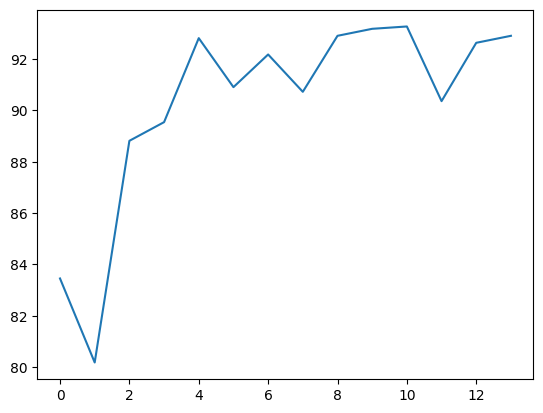

In [ ]:
plt.plot(val_accuracy)

In [ ]:
#SoftMax
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(Classifier.parameters(), lr=0.008)

num_epochs = 200

epoch_loss = []
val_loss = []
val_accuracy = []

best_loss = np.inf
best_weights = None
patience = 3
no_improvement = 0

for epoch in range(num_epochs):
    train_running_loss = 0.0
    mini_batch_loss = 0.0
    for batch_number, (images, labels) in enumerate(TrainingLoader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = Classifier(images)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
        mini_batch_loss += loss.item()

        if (batch_number + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}, Batch {batch_number + 1}, Loss: {mini_batch_loss / 32:.3f}')
            mini_batch_loss = 0.0

    epoch_loss.append(train_running_loss / len(TrainingLoader))

    # Validation
    correct = 0
    total = 0
    val_running_loss = 0.0

    for images, labels in ValidationLoader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = Classifier(images)
        loss = loss_function(outputs, labels)

        val_running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    val_accuracy.append(100 * correct / total)
    val_loss.append(val_running_loss / len(ValidationLoader))

    # Early Stopping
    if val_loss[-1] < best_loss:
        best_loss = val_loss[-1]
        best_weights = Classifier.state_dict()
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement == patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

    print(f'Epoch {epoch + 1} Loss: {train_running_loss / len(TrainingLoader):.3f}')
    print(f'Epoch {epoch + 1} Validation Accuracy: {val_accuracy[-1]:.2f}%')
    print(f'Epoch {epoch + 1} Validation Loss: {val_loss[-1]:.3f}')

print('Finished Training')

# Best Weights
Classifier.load_state_dict(best_weights)

print('Finished Training')

# Plots
plt.plot(range(1, len(epoch_loss) + 1), epoch_loss, label='Training Loss')
plt.plot(range(1, len(epoch_loss) + 1), val_loss, label='Validation Loss')


plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Progress')
plt.legend()
plt.show()


Epoch 1, Batch 10, Loss: 0.467
Epoch 1, Batch 20, Loss: 0.450
Epoch 1, Batch 30, Loss: 0.461
Epoch 1, Batch 40, Loss: 0.453
Epoch 1, Batch 50, Loss: 0.466
Epoch 1, Batch 60, Loss: 0.456
Epoch 1, Batch 70, Loss: 0.456
Epoch 1, Batch 80, Loss: 0.463
Epoch 1, Batch 90, Loss: 0.462
Epoch 1, Batch 100, Loss: 0.455
Epoch 1, Batch 110, Loss: 0.463
Epoch 1, Batch 120, Loss: 0.449
Epoch 1, Batch 130, Loss: 0.461
Epoch 1, Batch 140, Loss: 0.462
Epoch 1 Loss: 1.471
Epoch 1 Validation Accuracy: 29.91%
Epoch 1 Validation Loss: 1.447
Epoch 2, Batch 10, Loss: 0.469
Epoch 2, Batch 20, Loss: 0.438
Epoch 2, Batch 30, Loss: 0.461
Epoch 2, Batch 40, Loss: 0.451
Epoch 2, Batch 50, Loss: 0.460
Epoch 2, Batch 60, Loss: 0.461
Epoch 2, Batch 70, Loss: 0.460
Epoch 2, Batch 80, Loss: 0.456
Epoch 2, Batch 90, Loss: 0.458
Epoch 2, Batch 100, Loss: 0.461
Epoch 2, Batch 110, Loss: 0.463
Epoch 2, Batch 120, Loss: 0.466
Epoch 2, Batch 130, Loss: 0.451
Epoch 2, Batch 140, Loss: 0.468
Epoch 2 Loss: 1.469
Epoch 2 Validat

KeyboardInterrupt: ignored